In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

### Adjacency Matricies

In [2]:
def random_connectivity_matrix(n, med_frac = 1.0, source_rate = 0.1, all_source_connections = 0, random_state = 10):
    rng = np.random.RandomState(random_state) # fixed random state
    
    A = rng.rand(n, n)
    A = np.dot(A.T, A)
    np.fill_diagonal(A, 0)
    K = A.copy()

    for i in range(n):
        loc_thresh = min(med_frac * np.median(A[i, 1:]), max(A[i, 1:] * 0.99))
        ind = A[i, 1:] < loc_thresh
        ind = np.insert(ind, 0, False)
        K[i, ind] = 0
        K[ind, i] = 0

    S = np.sum(K > 0.0, axis=0)
    for i in range(n):
        if S[i] == 0 or (i == 1 and S[i] < 2):
            if i != 1:
                val, ind = max((val, idx) for idx, val in enumerate(A[i, 1:]))
                K[i, ind + 1] = val
                K[ind + 1, i] = val
            else:
                val, ind = max((val, idx) for idx, val in enumerate(A[i, 2:]))
                K[i, ind + 2] = val
                K[ind + 2, i] = val

    K /= np.max(K)
    if all_source_connections:
        K[0, :] = source_rate
        K[:, 0] = source_rate
    else:
        K[0, :] = 0.0
        K[:, 0] = 0.0

    K[0, 1] = source_rate
    K[1, 0] = source_rate

    return K

def random_zero_diagonal_matrix(size, random_state = 10):
    """Generates an adjacency matrix with zero diagonal."""
    rng = np.random.RandomState(random_state) # fixed random state
    A = rng.rand(size, size)
    np.fill_diagonal(A, 0)
    return A

def binary_fully_connected(size):
    """Generates an adjacency matrix with zero diagonal."""
    A = np.ones([size, size])
    np.fill_diagonal(A, 0)
    return A

def tridiagonal_matrix(size):
    """Generates a binary tridiagonal adjacency matrix with zero diagonal."""
    A = np.zeros((size, size))
    np.fill_diagonal(A[:-1, 1:], 1)
    np.fill_diagonal(A[1:, :-1], 1)
    return A

def binary_random_connections(size, max_connections, random_state=42):
    rng = np.random.RandomState(random_state)
    A = np.zeros((size, size), dtype=int)
    for i in range(size):
        connections = rng.choice(size, max_connections, replace=False)
        A[i, connections] = 1
    np.fill_diagonal(A, 0)
    return A

def compute_laplacian_matrix(A):
    """Generates the Laplacian matrix from the adjacency matrix as described by Garbarino."""
    degree_matrix = np.diag(np.sum(A, axis=1))
    laplacian_matrix = degree_matrix - A
    return laplacian_matrix

In [3]:
size = 3

A_random = random_connectivity_matrix(size)
print(f"random_connectivity_matrix:\n{A_random}")

A_random_zero_diag = random_zero_diagonal_matrix(size)
print(f"\nrandom_zero_diagonal_matrix:\n{A_random_zero_diag}")

A_tridiagonal = tridiagonal_matrix(size)
print(f"\ntridiagonal_matrix:\n{A_tridiagonal}")

A_random_connections = binary_random_connections(size, 2)
print(f"\binary_random_connections:\n{A_random_connections}")

A_full = binary_fully_connected(size)
print(f"\binary_fully_connected:\n{A_full}")

random_connectivity_matrix:
[[0.         0.1        0.        ]
 [0.1        0.         0.36756077]
 [0.         0.36756077 0.        ]]

random_zero_diagonal_matrix:
[[0.         0.02075195 0.63364823]
 [0.74880388 0.         0.22479665]
 [0.19806286 0.76053071 0.        ]]

tridiagonal_matrix:
[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]
inary_random_connections:
[[0 1 0]
 [0 0 1]
 [1 1 0]]
inary_fully_connected:
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


### Compute Laplacian

### Reaction Diffusion Model

In [4]:
def get_adjacency_matrix(matrix_type, size):
    """Return the selected adjacency matrix based on the matrix_type."""
    if matrix_type == "Random Zero Diagonal":
        return random_zero_diagonal_matrix(size)
    elif matrix_type == "Binary Zero Diagonal":
        return binary_zero_diagonal_matrix(size)
    elif matrix_type == "Tridiagonal":
        return tridiagonal_matrix(size)
    else:
        return tridiagonal_matrix(size)

def compute_laplacian_matrix(A):
    """Compute the Laplacian matrix from the adjacency matrix."""
    D = np.diag(np.sum(A, axis=1))
    return D - A

# RD Model with varying k_ij
def reaction_diffusion_model_varying_k_ij(A, H, k_ij_mean, nu_value=1.0, random_state=10):
    np.random.seed(random_state)
    n = A.shape[0]
    t = np.linspace(0, 100, 1000)
    dt = t[1] - t[0]  # time step

    # Randomize initial conditions between 0.05 and 0.1 for all biomarkers
    x0 = np.random.uniform(0.05, 0.1, n)

    # Varying k_ij based on input Gaussian mean
    k_ij = np.random.normal(loc=k_ij_mean, scale=0.1, size=n)  # Propagation rates
    K = np.diag(k_ij)

    # Set nu as constant
    nu = np.full(n, nu_value)  # Maximal concentration threshold
    R = np.random.uniform(0.1, 0.3, n)  # Aggregation rate

    x = np.zeros((n, len(t)))
    x[:, 0] = x0

    for i in range(1, len(t)):
        diffusion_term = np.dot((A * K), np.dot(H, x[:, i-1]))
        reaction_term = R * x[:, i-1] * (nu - x[:, i-1])
        dx_dt = diffusion_term + reaction_term

        # Euler integration with non-negativity constraint
        x[:, i] = x[:, i-1] + dt * dx_dt
        x[:, i] = np.maximum(x[:, i], 0)  # Enforce non-negativity

    return t, x

def reaction_diffusion_model(A, H, k_ij_mean, nu_mean, random_state=10):
    np.random.seed(random_state)
    n = A.shape[0]
    t = np.linspace(0, 100, 1000)
    dt = t[1] - t[0]  # time step

    # Randomize initial conditions between 0.05 and 0.1 for all biomarkers
    x0 = np.random.uniform(0.05, 0.1, n)

    # Varying k_ij and nu based on input Gaussian means
    k_ij = np.random.normal(loc=k_ij_mean, scale=0.1, size=n)  # propagation rates
    K = np.diag(k_ij)
    nu = np.random.normal(loc=nu_mean, scale=0.1, size=n)  # maximal conc threshold
    R = np.random.uniform(0.1, 0.3, n)  # aggregation rate

    x = np.zeros((n, len(t)))
    x[:, 0] = x0

    for i in range(1, len(t)):
        diffusion_term = np.dot((A * K), np.dot(H, x[:, i-1]))
        reaction_term = np.dot(R,x[:, i-1]) * (nu - x[:, i-1])
        dx_dt = diffusion_term + reaction_term

        # Euler integration with non-negativity constraint
        x[:, i] = x[:, i-1] + dt * dx_dt
        x[:, i] = np.maximum(x[:, i], 0)  # Enforce non-negativity

    return t, x


In [5]:
def plot_rd_interactive(k_ij_mean, nu_mean, matrix_type):
    size = 3
    A = get_adjacency_matrix(matrix_type, size)
    H = compute_laplacian_matrix(A)
    
    t, x = reaction_diffusion_model(A, H, k_ij_mean, nu_mean, random_state=10)
    
    plt.figure(figsize=(6, 6))
    for i in range(size):
        plt.plot(t, x[i], label=f'Biomarker {i+1}')
    
    plt.title(f"RD Model with k_ij_mean={k_ij_mean:.2f}, nu_mean={nu_mean:.2f}\nMatrix: {matrix_type}")
    plt.xlabel('Time')
    plt.ylabel('Biomarker Value')
    plt.legend()
    plt.show()

# Interactive sliders for the combined RD model
interact(plot_rd_interactive,
         k_ij_mean=widgets.FloatSlider(value=0.5, min=0.05, max=1.0, step=0.05),  # Varying k_ij as per paper
         nu_mean=widgets.FloatSlider(value=1.0, min=0.5, max=3.0, step=0.1),    # Varying nu as per paper
         matrix_type=widgets.Dropdown(options=["Random Zero Diagonal", "Binary Zero Diagonal", "Tridiagonal"], value="Tridiagonal"))

interactive(children=(FloatSlider(value=0.5, description='k_ij_mean', max=1.0, min=0.05, step=0.05), FloatSlid…

<function __main__.plot_rd_interactive(k_ij_mean, nu_mean, matrix_type)>

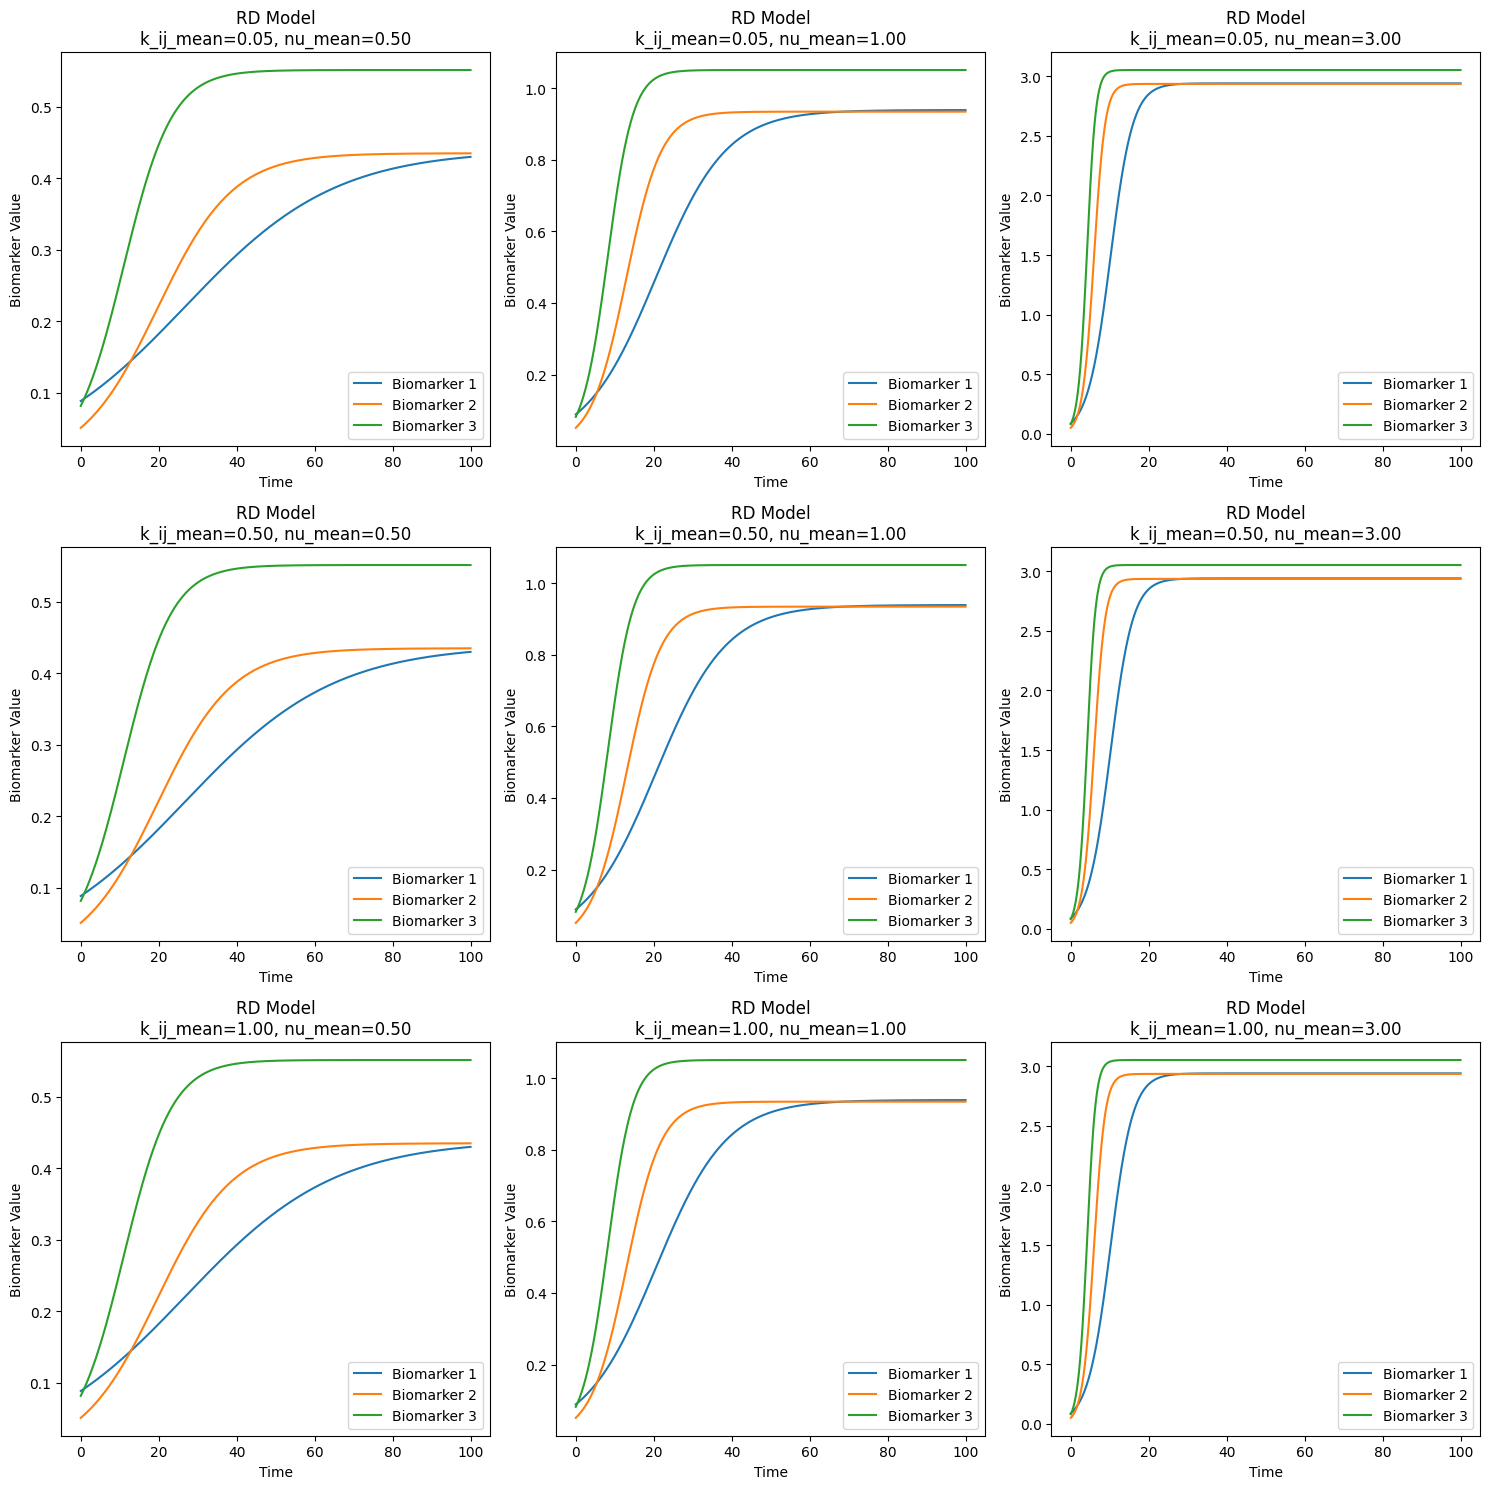

In [6]:
def plot_rd_subplot():
    size = 3
    matrix_types = ["Tridiagonal"]  # Change matrix types here if needed

    # Parameter sets for k_ij and nu as per the paper
    k_ij_means = [0.05, 0.5, 1.0]  # Different k_ij means
    nu_means = [0.5, 1.0, 3.0]     # Different nu means

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()  # flatten the axes for better indexing

    idx = 0
    for k_ij_mean in k_ij_means:
        for nu_mean in nu_means:
            A = get_adjacency_matrix("Tridiagonal", size)  # Change connectivity matrix here if needed
            H = compute_laplacian_matrix(A)
            
            t, x = reaction_diffusion_model(A, H, k_ij_mean, nu_mean, random_state=10)
            
            ax = axes[idx]
            for i in range(size):
                ax.plot(t, x[i], label=f'Biomarker {i+1}')
            
            title = f"RD Model\nk_ij_mean={k_ij_mean:.2f}, nu_mean={nu_mean:.2f}"
            ax.set_title(title)
            ax.set_xlabel('Time')
            ax.set_ylabel('Biomarker Value')
            ax.legend()
            
            idx += 1
    
    plt.tight_layout()
    plt.show()

plot_rd_subplot()